# Feature Engineering

En este notebook se buscan atributos nuevos para concatenar al set de datos original, así pudiendo armar un modelo predictivo más robusto y eficiente.



In [1]:
# Importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default')

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('../data/train_cleaned.csv', index_col='building_id', low_memory=False)
df_test = pd.read_csv('../data/test_cleaned.csv', index_col='building_id', low_memory=False)

In [3]:
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
28830,2,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
94947,3,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
590882,2,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
201944,3,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Conversion de tipos de datos
to_categorical = set(df_train.select_dtypes(include='object').columns.tolist())
to_bool = set([col for col in df_train.columns if 'has' in col])
to_numeric = set(df_train.select_dtypes(include='int64').columns.tolist()) - to_bool

for col in to_categorical:
    df_train[col] = df_train[col].astype('category')

for col in to_bool:
    df_train[col] = df_train[col].astype('bool')

for col in to_numeric:
    df_train[col] = pd.to_numeric(df_train[col], downcast='unsigned')


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   damage_grade                            260601 non-null  uint8   
 1   geo_level_1_id                          260601 non-null  uint8   
 2   geo_level_2_id                          260601 non-null  uint16  
 3   geo_level_3_id                          260601 non-null  uint16  
 4   count_floors_pre_eq                     260601 non-null  uint8   
 5   age                                     260601 non-null  uint8   
 6   area_percentage                         260601 non-null  uint8   
 7   height_percentage                       260601 non-null  uint8   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                  

In [7]:
df_train.isnull().sum()

damage_grade                              0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [8]:
df_test.isnull().sum()

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

## Graficos de correlaciones entre variables con el dataset inicial

La columna has_secondary_use ya vimos que tiene informacion redundante con las de has_secondary_use_X

In [9]:
def drop_features_redundantes(df, features):
    df.drop(columns=features, inplace=True)

In [10]:
features_redundantes = ['has_secondary_use']
drop_features_redundantes(df_train, features_redundantes)

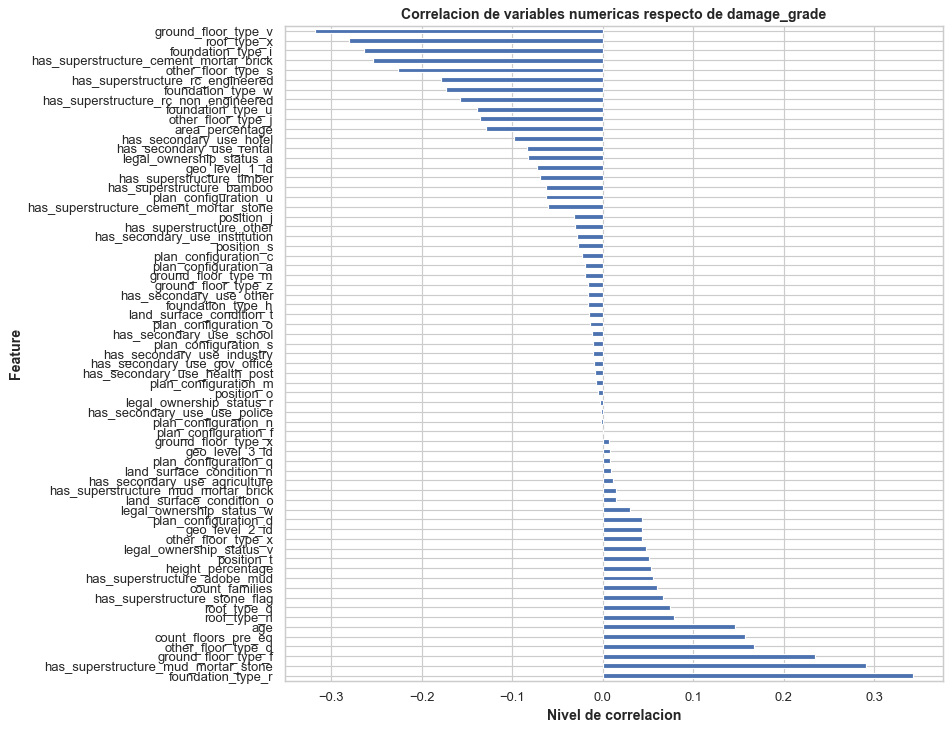

In [11]:
# Correlacion negativa --> una variable decrece mientras la otra crece o viceversa
# Correlacion positiva --> una varibale crece mientras la otra tambien, o las dos decrecen.

# Paso las features categoricas como columnas booleanas
features_categoricos = df_train.select_dtypes(include=['category']).columns.tolist()
df_con_categoricos = pd.get_dummies(df_train, prefix_sep='_', columns=features_categoricos, drop_first=False)

plt.figure(figsize=(10,10), dpi=85)
plt.title("Correlacion de variables numericas respecto de damage_grade", weight='bold')
df_con_categoricos.corr()['damage_grade'].drop('damage_grade').sort_values(ascending=False).plot.barh()
plt.ylabel('Feature', weight='bold')
plt.xlabel("Nivel de correlacion", weight='bold')
plt.show()

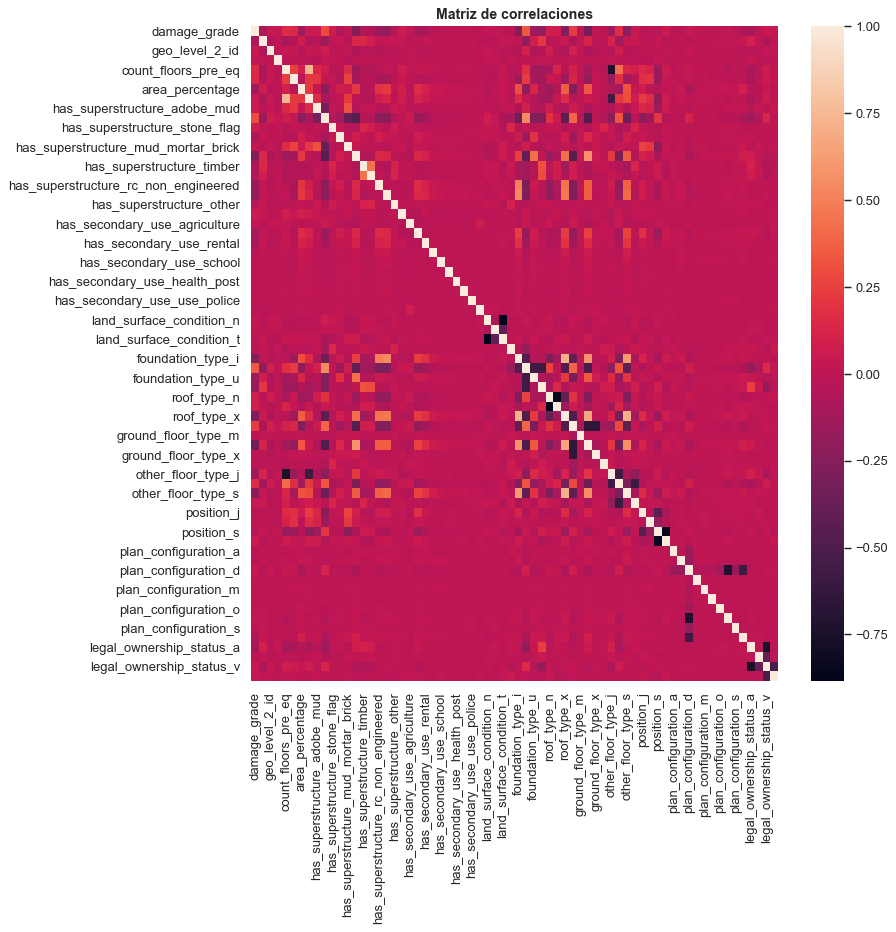

In [12]:
# Heatmap de correlaciones
plt.figure(figsize=(10, 10), dpi=85)
plt.title("Matriz de correlaciones", weight='bold')
sns.heatmap(df_con_categoricos.corr())
plt.show()

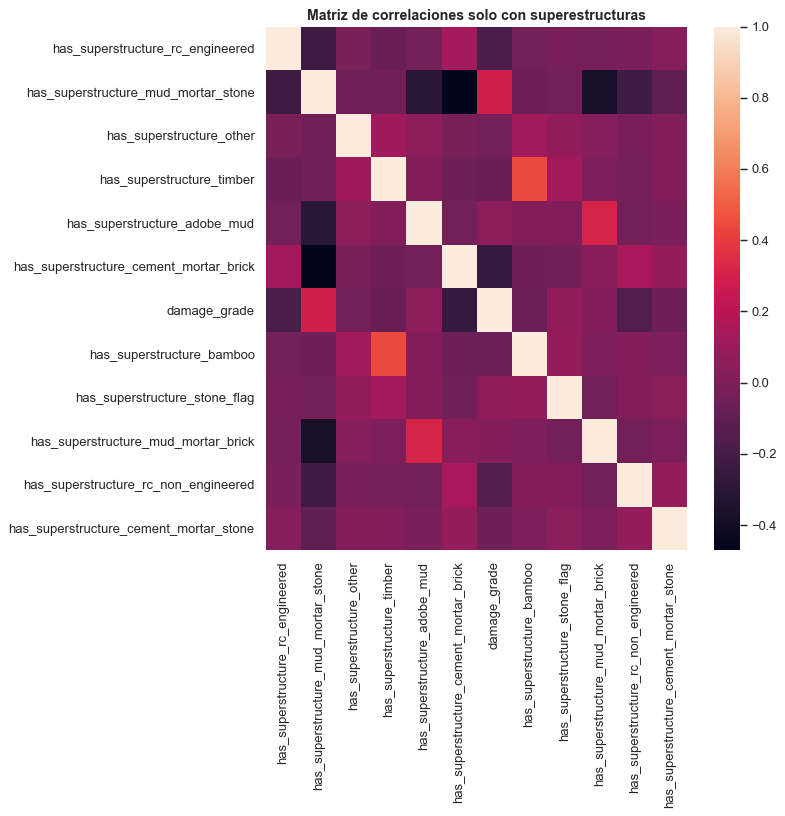

In [13]:
has_superstructure = set([col for col in df_train.columns if 'has_superstructure' in col]).union(set(['damage_grade']))
plt.figure(figsize=(8,8), dpi=85)
plt.title("Matriz de correlaciones solo con superestructuras", weight='bold')
sns.heatmap(df_train.loc[:, has_superstructure].corr())
plt.show()

## Creacion de nuevas features a partir de columnas actuales

### Trabajando con los geo_level_ids

#### Enfoque de probabilidad condicional (algo similar a Target/Mean Encoding)

Sabemos que los geo_level_ids tienen una alta cardinalidad para los tres tipos de IDs, pero ademas si usaramos los IDs tal y como estan podria pasar que introducieramos un cierto 'orden' que no represente lo que en realidad significan esos IDs geo-espaciales, generando una posible molestia a los modelos. Por esto, buscamos aplicar probabilidad condicional de manera de obtener, por ejemplo, 
$ P(damage\_grade = 1 \ | \ geo\_level\_1 = 14) $. Por ende, por cada columna de geo_level_id obtendriamos 3 nuevas features. El potencial problema de esto es que estariamos leakeando informacion tanto al set de test a usar para medir el score de nuestros modelos, como al set de test al cual debemos de predecir las labels para DrivenData.

> https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53

> https://stackoverflow.com/questions/33468976/pandas-conditional-probability-of-a-given-specific-b

In [14]:
# Vemos que cada columna suma 1.
prueba = pd.crosstab(df_train['damage_grade'], df_train['geo_level_1_id'], normalize='columns')
prueba

geo_level_1_id,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
damage_grade,,,,,,,,,,,,,,,,,,,,,
1,0.08,0.15,0.09,0.03,0.04,0.17,0.09,0.05,0.03,0.14,...,0.02,0.13,0.06,0.21,0.08,0.35,0.04,0.00,0.02,0.09
2,0.77,0.73,0.66,0.60,0.77,0.75,0.67,0.59,0.45,0.69,...,0.39,0.74,0.69,0.69,0.78,0.56,0.48,0.59,0.88,0.79
3,0.15,0.11,0.25,0.36,0.20,0.09,0.25,0.35,0.52,0.17,...,0.58,0.13,0.25,0.10,0.14,0.09,0.48,0.41,0.10,0.11


In [15]:
prueba = prueba.T
prueba.head()

damage_grade,1,2,3
geo_level_1_id,,,
0,0.08,0.77,0.15
1,0.15,0.73,0.11
2,0.09,0.66,0.25
3,0.03,0.60,0.36
4,0.04,0.77,0.20


In [16]:
prueba[1].get(1, 0)

0.15216586449463163

In [17]:
prueba[1].get(54, 0)

0

In [18]:
def calcular_proba_condicional_segun_geo_level_id(df_train, df_test, feature_geo_level):
    
    # Esta parte calcula las probas segun el set de train y agrega las columnas correspondientes al set de train
    probas_condicionales = pd.crosstab(df_train['damage_grade'], df_train[feature_geo_level], normalize='columns')
    label_spliteado = feature_geo_level.split('_')
    aux_feature_geo_level = label_spliteado[0] + label_spliteado[1] + label_spliteado[2]
    df_train['proba_danio_1_dado_' + aux_feature_geo_level] = df_train[feature_geo_level].map(lambda _id: probas_condicionales[_id][1])
    df_train['proba_danio_2_dado_' + aux_feature_geo_level] = df_train[feature_geo_level].map(lambda _id: probas_condicionales[_id][2])
    df_train['proba_danio_3_dado_' + aux_feature_geo_level] = df_train[feature_geo_level].map(lambda _id: probas_condicionales[_id][3])
    
    # Usa las probas calculadas en el set de train para agregar las columnas al set de test
    # En el caso de que un ID exista en test pero no en train se completa con 0
    probas_condicionales = probas_condicionales.T
    df_test['proba_danio_1_dado_' + aux_feature_geo_level] = df_test[feature_geo_level].map(lambda _id: probas_condicionales[1].get(_id, 0))
    df_test['proba_danio_2_dado_' + aux_feature_geo_level] = df_test[feature_geo_level].map(lambda _id: probas_condicionales[2].get(_id, 0))
    df_test['proba_danio_3_dado_' + aux_feature_geo_level] = df_test[feature_geo_level].map(lambda _id: probas_condicionales[3].get(_id, 0))

In [19]:
# Esta llamada tarda un poquito
calcular_proba_condicional_segun_geo_level_id(df_train, df_test, 'geo_level_1_id')
calcular_proba_condicional_segun_geo_level_id(df_train, df_test, 'geo_level_2_id')
calcular_proba_condicional_segun_geo_level_id(df_train, df_test, 'geo_level_3_id')

In [20]:
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,proba_danio_1_dado_geolevel1,proba_danio_2_dado_geolevel1,proba_danio_3_dado_geolevel1,proba_danio_1_dado_geolevel2,proba_danio_2_dado_geolevel2,proba_danio_3_dado_geolevel2,proba_danio_1_dado_geolevel3,proba_danio_2_dado_geolevel3,proba_danio_3_dado_geolevel3
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,False,0.09,0.67,0.25,0.00,0.25,0.74,0.00,0.16,0.84
28830,2,8,900,2812,2,10,8,7,o,r,...,False,0.03,0.45,0.52,0.01,0.49,0.50,0.06,0.81,0.12
94947,3,21,363,8973,2,10,5,5,t,r,...,False,0.02,0.39,0.58,0.08,0.32,0.60,0.03,0.36,0.61
590882,2,22,418,10694,2,10,6,5,t,r,...,False,0.13,0.74,0.13,0.02,0.85,0.13,0.03,0.84,0.13
201944,3,11,131,1488,3,30,8,9,t,r,...,False,0.05,0.57,0.38,0.03,0.59,0.38,0.01,0.61,0.38


In [21]:
df_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_other,proba_danio_1_dado_geolevel1,proba_danio_2_dado_geolevel1,proba_danio_3_dado_geolevel1,proba_danio_1_dado_geolevel2,proba_danio_2_dado_geolevel2,proba_danio_3_dado_geolevel2,proba_danio_1_dado_geolevel3,proba_danio_2_dado_geolevel3,proba_danio_3_dado_geolevel3
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0.01,0.18,0.81,0.01,0.28,0.71,0.05,0.26,0.68
99355,6,141,11987,2,25,13,5,t,r,n,...,0,0.09,0.67,0.25,0.00,0.82,0.18,0.00,1.00,0.00
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0.13,0.74,0.13,0.00,0.82,0.17,0.00,0.00,1.00
745817,26,39,633,1,0,19,3,t,r,x,...,0,0.35,0.56,0.09,0.51,0.45,0.04,0.57,0.42,0.01
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0.01,0.18,0.81,0.01,0.30,0.69,0.00,0.18,0.82


#### Enfoque de feature embedding usando redes neuronales

Como tenemos una alta cardinalidad de IDs para los tres tipos, la idea es usar embedding similar al que se usa para textos (Word2Vec) pero con redes neuronales para casos categoricos numericos, como es en este caso los IDs. Un embedding representa una data categorica en un vector de una dimensional menor a la feature que se esta analizando. Por ejemplo, si la feature es de $ R^N $ entonces el mappeo de embedding lo hace de $ R^N -> R^M $ el cual es un espacio de menos dimensiones. Es decir, actua como si fuera un 'compresor'.

Desde el punto de vista del score para la competencia, nos genera una mejora importante (~0.03). Sin embargo, desconocemos si tiene una utilidad real productiva. Por ejemplo, ¿que representan los geo level embedded para un modelo? ¿Tiene sentido conocer la ubicacion de una casa a la hora de saber cuanto daño va a recibir por un terremoto? ¿Tenemos en cuenta si la casa se encuentra en el epicentro del terremoto o si esta mas alejada?

> https://towardsdatascience.com/why-you-should-always-use-feature-embeddings-with-structured-datasets-7f280b40e716

> https://towardsdatascience.com/deep-learning-structured-data-8d6a278f3088

> https://medium.com/kirey-group/autoembedder-training-embedding-layers-on-unsupervised-tasks-fc364c0f6eec

> https://blog.keras.io/building-autoencoders-in-keras.html

> https://machinelearningmastery.com/autoencoder-for-classification/

> https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer

> https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

> https://towardsdatascience.com/understanding-entity-embeddings-and-its-application-69e37ae1501d

> https://medium.com/bcggamma/a-better-way-forecasting-with-embeddings-8f45e7065f2b

In [22]:
pd.concat([df_train['geo_level_1_id'], df_test['geo_level_1_id']])

building_id
802906      6
28830       8
94947      21
590882     22
201944     11
           ..
310028      4
663567     10
1049160    22
442785      6
501372     26
Name: geo_level_1_id, Length: 347469, dtype: int64

In [23]:
pd.get_dummies(pd.concat([df_train['geo_level_1_id'], df_test['geo_level_1_id']]))

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
building_id,,,,,,,,,,,,,,,,,,,,,
802906,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28830,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
94947,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
590882,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
201944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1049160,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [24]:
np.array(pd.get_dummies(pd.concat([df_train['geo_level_1_id'], df_test['geo_level_1_id']])))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [25]:
def concatenar_todos_los_geo_ids(df_train, df_test):
    '''
    Concatena todos los geo level IDs de ambos datasets.
    '''
    # Necesitamos convertirlo a un np.array para que la NN pueda trabajar
    geo_level_1 = np.array(pd.get_dummies(pd.concat([df_train['geo_level_1_id'], df_test['geo_level_1_id']])))
    geo_level_2 = np.array(pd.get_dummies(pd.concat([df_train['geo_level_2_id'], df_test['geo_level_1_id']])))
    geo_level_3 = np.array(pd.get_dummies(pd.concat([df_train['geo_level_3_id'], df_test['geo_level_3_id']])))
    return geo_level_1, geo_level_2, geo_level_3

geo_level_1, geo_level_2, geo_level_3 = concatenar_todos_los_geo_ids(df_train, df_test)

In [26]:
geo_level_3.shape

(347469, 11861)

In [27]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from time import ctime
import os.path

# https://keras.io/guides/functional_api/
CANT_NEURONAS = 16
def crear_red_neuronal():
    '''
    La cantidad de neuronas nos define la cantidad de nuevas features (columnas)
    a generar para representar los IDs ya que vamos a tomar el output de la capa intermedia como encoder.
    La idea es pasar a la NN los geo level 3 y que devuelva los geo level 1 y 2.
    Intentando al reves (input con geo level 1 y 2) y output geo level 3 consume mucha memoria.
    '''
    shape_inicial = geo_level_3.shape[1]
    # Creamos el input
    input_inicial = Input(shape=(shape_inicial, ))
    # Creamos las capas
    layer_1 = Dense(CANT_NEURONAS, name='capa_intermedia')(input_inicial)
    layer_2a = Dense(geo_level_2.shape[1], activation='sigmoid', name='salida_1')(layer_1)
    layer_2b = Dense(geo_level_1.shape[1], activation='sigmoid', name='salida_2')(layer_1)
    # Agregamos las capas al modelo
    model = Model(inputs=input_inicial, outputs=[layer_2a, layer_2b])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def entrenar_red_neuronal(model):
    '''
    Recibe un modelo de NN creado con crear_red_neuronal()
    '''
    if os.path.isfile('./geo_level_encoding.h5'):
        print('Archivo con weights de las capas cargado')
        model.load_weights('./geo_level_encoding.h5')
    else:
        print('Hora al empezar a entrenar: {}'.format(ctime()))
        model.fit(geo_level_3, [geo_level_2, geo_level_1], batch_size=128, epochs=10, verbose=2)
        # Guardamos el modelo para NO tener que entrenarlo siempre ya que consume tiempo
        print('Hora al finalizar de entrenar: {}'.format(ctime()))
        model.save('geo_level_encoding.h5')
    return model

In [28]:
model = crear_red_neuronal()
model = entrenar_red_neuronal(model)

Archivo con weights de las capas cargado


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11861)]      0                                            
__________________________________________________________________________________________________
capa_intermedia (Dense)         (None, 16)           189792      input_1[0][0]                    
__________________________________________________________________________________________________
salida_1 (Dense)                (None, 1415)         24055       capa_intermedia[0][0]            
__________________________________________________________________________________________________
salida_2 (Dense)                (None, 31)           527         capa_intermedia[0][0]            
Total params: 214,374
Trainable params: 214,374
Non-trainable params: 0
______________________

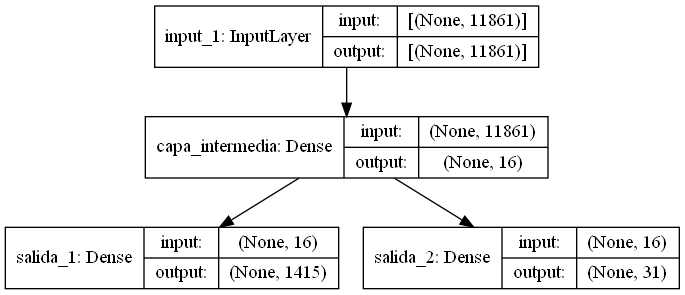

In [30]:
# https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('capa_intermedia').output)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [31]:
display(model.input)
display(model.get_layer('capa_intermedia').output)

<KerasTensor: shape=(None, 11861) dtype=float32 (created by layer 'input_1')>

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'capa_intermedia')>

In [32]:
# Prueba
pruebita = []
for data in geo_level_3[: 3]:
    data = data.reshape((1, data.shape[0]))
    pruebita.append(data)
    print(intermediate_layer_model(data)[0])
    print(data)
    print(data.ndim)
    print(data.shape)

tf.Tensor(
[ 1.3600111   1.7999294  -1.7193885   0.1890164   0.4914781   1.5777125
  0.5717521  -1.5775952   1.4216924   1.0147291   1.41172    -1.4985005
  0.2260428  -1.1527451  -0.04018855  1.2390574 ], shape=(16,), dtype=float32)
[[0 0 0 ... 0 0 0]]
2
(1, 11861)
tf.Tensor(
[ 0.03887713  0.61659575  0.34828115  0.6424698  -1.1372623   0.86404955
  1.4494145  -0.36701667  0.5800556   0.5084475   1.149173   -0.7371247
 -0.74344206 -0.626146    2.4050019   1.7022061 ], shape=(16,), dtype=float32)
[[0 0 0 ... 0 0 0]]
2
(1, 11861)
tf.Tensor(
[ 1.3469492  -0.5384051  -0.9722486  -0.7696333  -0.9253024   1.5982683
  0.22143006 -1.6499966   2.1668558   2.059422   -0.74307305 -1.6434052
 -1.1269667  -1.3510317   2.3333876   2.0083432 ], shape=(16,), dtype=float32)
[[0 0 0 ... 0 0 0]]
2
(1, 11861)


In [33]:
cant_registros = df_train.shape[0]
def extraer_y_agregar_geo_embebidas(df, train_o_test='train'):
    '''
    Extrae los outputs de la capa intermedia y los agrega al dataset
    '''
    def extraer_geo_embebidas(data, output):
        data = data.reshape((1, data.shape[0]))
        layer_output = intermediate_layer_model(data)[0]
        output.append(layer_output)
    
    output = []
    if train_o_test == 'train':
        for data in geo_level_3[: cant_registros]:
            # Extraemos los outputs de la capa intermedia
            extraer_geo_embebidas(data, output)
    else:
        for data in geo_level_3[cant_registros: ]:
            extraer_geo_embebidas(data, output)
    # Formateo, volviendo todo un vector con 1 fila y (CANT_NEURONAS) de columnas
    output = np.array(output)
    output = np.squeeze(output)
    # Los agregamos al dataset
    for i in range(0, CANT_NEURONAS):
        df['geo_level_embedded_' + str(i)] = output[:, i]

In [34]:
if os.path.isfile('../data/train_geo_embedded.csv'):
    aux = pd.read_csv('../data/train_geo_embedded.csv', index_col='building_id')
    df_train = df_train.join(aux, on='building_id')
else:
    extraer_y_agregar_geo_embebidas(df_train, 'train')

In [35]:
if os.path.isfile('../data/test_geo_embedded.csv'):
    aux = pd.read_csv('../data/test_geo_embedded.csv', index_col='building_id')
    df_test = df_test.join(aux, on='building_id')
else:
    extraer_y_agregar_geo_embebidas(df_test, 'test')

In [36]:
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,geo_level_embedded_6,geo_level_embedded_7,geo_level_embedded_8,geo_level_embedded_9,geo_level_embedded_10,geo_level_embedded_11,geo_level_embedded_12,geo_level_embedded_13,geo_level_embedded_14,geo_level_embedded_15
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0.57,-1.58,1.42,1.01,1.41,-1.50,0.23,-1.15,-0.04,1.24
28830,2,8,900,2812,2,10,8,7,o,r,...,1.45,-0.37,0.58,0.51,1.15,-0.74,-0.74,-0.63,2.41,1.70
94947,3,21,363,8973,2,10,5,5,t,r,...,0.22,-1.65,2.17,2.06,-0.74,-1.64,-1.13,-1.35,2.33,2.01
590882,2,22,418,10694,2,10,6,5,t,r,...,1.70,-0.46,1.50,1.52,1.25,-1.21,-0.95,0.57,1.04,2.27
201944,3,11,131,1488,3,30,8,9,t,r,...,1.85,-0.95,2.06,1.04,2.07,-0.29,-1.38,-1.38,0.17,2.21


In [37]:
df_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,geo_level_embedded_6,geo_level_embedded_7,geo_level_embedded_8,geo_level_embedded_9,geo_level_embedded_10,geo_level_embedded_11,geo_level_embedded_12,geo_level_embedded_13,geo_level_embedded_14,geo_level_embedded_15
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0.72,-0.28,1.29,0.48,1.13,0.49,0.37,-1.16,0.96,1.67
99355,6,141,11987,2,25,13,5,t,r,n,...,0.99,-0.59,0.89,-0.06,1.08,-0.76,0.40,-1.01,1.05,0.53
890251,22,19,10044,2,5,4,5,t,r,n,...,1.20,0.20,1.09,1.34,1.11,-0.61,-0.91,0.34,1.01,1.47
745817,26,39,633,1,0,19,3,t,r,x,...,0.06,-0.71,1.01,2.34,2.26,0.72,-2.49,-0.79,3.09,1.92
421793,17,289,7970,3,15,8,7,t,r,q,...,0.24,-0.13,1.80,0.66,1.47,0.38,0.14,-0.96,0.56,1.68


### Features basadas en geo level id

In [38]:
def features_geo_level(df):
    df['cant_geolevel1'] = df.groupby('geo_level_1_id')['geo_level_1_id'].transform('count')
    df['cant_geolevel2'] = df.groupby('geo_level_2_id')['geo_level_2_id'].transform('count')
    df['cant_geolevel3'] = df.groupby('geo_level_3_id')['geo_level_3_id'].transform('count')
    cant_geo_level = [col for col in df.columns if 'cant_geolevel' in col]
    for col1 in cant_geo_level:
        for col2 in cant_geo_level:
            if col1 == col2:
                continue
            aux_label = 'relacion_' + col1.split('_')[1] + '_' + col2.split('_')[1]
            df[aux_label] = df[col1] / df[col2]

In [39]:
features_geo_level(df_train)

In [40]:
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,geo_level_embedded_15,cant_geolevel1,cant_geolevel2,cant_geolevel3,relacion_geolevel1_geolevel2,relacion_geolevel1_geolevel3,relacion_geolevel2_geolevel1,relacion_geolevel2_geolevel3,relacion_geolevel3_geolevel1,relacion_geolevel3_geolevel2
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,1.24,24381,270,37,90.30,658.95,0.01,7.30,0.00,0.14
28830,2,8,900,2812,2,10,8,7,o,r,...,1.70,19080,199,16,95.88,"1,192.50",0.01,12.44,0.00,0.08
94947,3,21,363,8973,2,10,5,5,t,r,...,2.01,14889,1760,136,8.46,109.48,0.12,12.94,0.01,0.08
590882,2,22,418,10694,2,10,6,5,t,r,...,2.27,6252,205,31,30.50,201.68,0.03,6.61,0.00,0.15
201944,3,11,131,1488,3,30,8,9,t,r,...,2.21,8220,1038,122,7.92,67.38,0.13,8.51,0.01,0.12


In [41]:
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,geo_level_embedded_15,cant_geolevel1,cant_geolevel2,cant_geolevel3,relacion_geolevel1_geolevel2,relacion_geolevel1_geolevel3,relacion_geolevel2_geolevel1,relacion_geolevel2_geolevel3,relacion_geolevel3_geolevel1,relacion_geolevel3_geolevel2
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,1.24,24381,270,37,90.30,658.95,0.01,7.30,0.00,0.14
28830,2,8,900,2812,2,10,8,7,o,r,...,1.70,19080,199,16,95.88,"1,192.50",0.01,12.44,0.00,0.08
94947,3,21,363,8973,2,10,5,5,t,r,...,2.01,14889,1760,136,8.46,109.48,0.12,12.94,0.01,0.08
590882,2,22,418,10694,2,10,6,5,t,r,...,2.27,6252,205,31,30.50,201.68,0.03,6.61,0.00,0.15
201944,3,11,131,1488,3,30,8,9,t,r,...,2.21,8220,1038,122,7.92,67.38,0.13,8.51,0.01,0.12


In [42]:
df_test.head(1)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,geo_level_embedded_6,geo_level_embedded_7,geo_level_embedded_8,geo_level_embedded_9,geo_level_embedded_10,geo_level_embedded_11,geo_level_embedded_12,geo_level_embedded_13,geo_level_embedded_14,geo_level_embedded_15
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0.72,-0.28,1.29,0.48,1.13,0.49,0.37,-1.16,0.96,1.67


### Features basadas en la antiguedad del edificio

In [43]:
def calcular_anio_edificacion(df):
    # Los datos fueron recolectados en 2015
    df['anio_edificacion'] = 2015 - df['age']
    # En Nepal en 1994 se crea el codigo de construccion a tener en cuenta para que
    # los edificios sean resistentes a terremetos
    df['construida_antes_de_codigo'] = 1994 < df['anio_edificacion']
    

In [44]:
calcular_anio_edificacion(df_train)
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,cant_geolevel2,cant_geolevel3,relacion_geolevel1_geolevel2,relacion_geolevel1_geolevel3,relacion_geolevel2_geolevel1,relacion_geolevel2_geolevel3,relacion_geolevel3_geolevel1,relacion_geolevel3_geolevel2,anio_edificacion,construida_antes_de_codigo
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,270,37,90.30,658.95,0.01,7.30,0.00,0.14,1985,False
28830,2,8,900,2812,2,10,8,7,o,r,...,199,16,95.88,"1,192.50",0.01,12.44,0.00,0.08,2005,True
94947,3,21,363,8973,2,10,5,5,t,r,...,1760,136,8.46,109.48,0.12,12.94,0.01,0.08,2005,True
590882,2,22,418,10694,2,10,6,5,t,r,...,205,31,30.50,201.68,0.03,6.61,0.00,0.15,2005,True
201944,3,11,131,1488,3,30,8,9,t,r,...,1038,122,7.92,67.38,0.13,8.51,0.01,0.12,1985,False


In [45]:
df_train['construida_antes_de_codigo'].value_counts()

True     166826
False     93775
Name: construida_antes_de_codigo, dtype: int64

### Features basados en cantidad de pisos, area, altura y cantidad de familias

In [46]:
def features_promedio_diferencia_categoricos(df):
    '''
    Agrupamos por categoria y hallamos la desviacion respecto al promedio
    por cada numerico y por cada categoria.
    '''
    categoricos = ['foundation_type', 'roof_type', 'ground_floor_type', 'position', 'plan_configuration', 'other_floor_type', 'land_surface_condition']
    numericos = ['age', 'area_percentage', 'height_percentage', 'count_floors_pre_eq']
    for cat in categoricos:
        for num in numericos:
            label = 'prom_' + cat + '_' + num
            df[label] = df.groupby(cat)[num].transform('mean')
            df['diff_' + label] = df[num] - df[label]

# En algunos casos hago df['age'] + 1 ya que hay casos con 0 años de antiguedad
def features_basadas_en_cantidad_de_pisos(df):
    df['cant_pisos_por_antiguedad'] = df['count_floors_pre_eq'] / (df['age'] + 1)
    df['cant_pisos_por_area'] = df['count_floors_pre_eq'] / df['area_percentage']
    df['cant_pisos_por_altura'] = df['count_floors_pre_eq'] / df['height_percentage']
    
def features_basadas_en_area_altura(df):
    df['area_por_antiguedad'] = df['area_percentage'] / (df['age'] + 1)
    df['altura_por_antiguedad'] = df['height_percentage'] / (df['age'] + 1)
    df['area_por_altura'] = df['area_percentage'] / df['height_percentage']
    df['producto_area_altura'] = df['area_percentage'] * df['height_percentage']
    df['area_al_cuadrado'] = df['area_percentage'] ** 2
    df['altura_al_cuadrado'] = df['height_percentage'] ** 2
    df['promedio_area_altura'] = (df['area_percentage'] + df['height_percentage']) / 2

def features_basadas_en_cantidad_familias(df):
    df['cant_familias_por_pisos'] = df['count_families'] / df['count_floors_pre_eq']
    df['cant_familias_por_area'] = df['count_families'] / df['area_percentage']
    df['cant_familias_por_altura'] = df['count_families'] / df['height_percentage']

In [47]:
#features_promedio_diferencia_categoricos(df_train)
features_basadas_en_cantidad_de_pisos(df_train)
features_basadas_en_area_altura(df_train)
features_basadas_en_cantidad_familias(df_train)
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,area_por_antiguedad,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0.19,0.16,1.20,30,36,25,5.50,0.50,0.17,0.20
28830,2,8,900,2812,2,10,8,7,o,r,...,0.73,0.64,1.14,56,64,49,7.50,0.50,0.12,0.14
94947,3,21,363,8973,2,10,5,5,t,r,...,0.45,0.45,1.00,25,25,25,5.00,0.50,0.20,0.20
590882,2,22,418,10694,2,10,6,5,t,r,...,0.55,0.45,1.20,30,36,25,5.50,0.50,0.17,0.20
201944,3,11,131,1488,3,30,8,9,t,r,...,0.26,0.29,0.89,72,64,81,8.50,0.33,0.12,0.11


### Features basados en uso secundario y tipo de superestructura

In [48]:
def features_basados_en_superestructura(df):
    has_superstructure = set([col for col in df.columns if 'has_superstructure' in col])
    only_superstructure = df.loc[:, has_superstructure]
    only_superstructure['cant_materiales'] = only_superstructure.sum(axis=1, numeric_only=True)
    result = df.join(only_superstructure['cant_materiales'], on='building_id')
    return result

In [49]:
df_train = features_basados_en_superestructura(df_train)
df_train.head()

,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,6,487,12198,2,30,6,5,t,r,...,0.16,1.20,30,36,25,5.50,0.50,0.17,0.20,2
28830,2,8,900,2812,2,10,8,7,o,r,...,0.64,1.14,56,64,49,7.50,0.50,0.12,0.14,1
94947,3,21,363,8973,2,10,5,5,t,r,...,0.45,1.00,25,25,25,5.00,0.50,0.20,0.20,1
590882,2,22,418,10694,2,10,6,5,t,r,...,0.45,1.20,30,36,25,5.50,0.50,0.17,0.20,3
201944,3,11,131,1488,3,30,8,9,t,r,...,0.29,0.89,72,64,81,8.50,0.33,0.12,0.11,1


### Encoding de variables categoricas

> https://contrib.scikit-learn.org/category_encoders/

In [50]:
categoricos = set(df_train.select_dtypes(include='category').columns.tolist())
for cat in categoricos:
    tipos_posibles = df_train[cat].nunique()
    print('La columna {} tiene {} tipos posibles'.format(cat, tipos_posibles))

La columna foundation_type tiene 5 tipos posibles
La columna ground_floor_type tiene 5 tipos posibles
La columna plan_configuration tiene 10 tipos posibles
La columna position tiene 4 tipos posibles
La columna legal_ownership_status tiene 4 tipos posibles
La columna other_floor_type tiene 4 tipos posibles
La columna land_surface_condition tiene 3 tipos posibles
La columna roof_type tiene 3 tipos posibles


In [51]:
df_train['plan_configuration'].value_counts()

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

In [52]:
df_train['foundation_type'].value_counts()

r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

In [53]:
df_train['land_surface_condition'].value_counts()

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

In [54]:
df_train['other_floor_type'].value_counts()

q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64

In [55]:
df_train['roof_type'].value_counts()

n    182842
q     61576
x     16183
Name: roof_type, dtype: int64

In [56]:
df_train['legal_ownership_status'].value_counts()

v    250939
a      5512
w      2677
r      1473
Name: legal_ownership_status, dtype: int64

In [57]:
df_train['ground_floor_type'].value_counts()

f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64

In [58]:
df_train['position'].value_counts()

s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64

#### Target encoding

> https://maxhalford.github.io/blog/target-encoding/

In [59]:
# Funcion sacada de https://maxhalford.github.io/blog/target-encoding/
def calc_smooth_mean(df_train, df_test, feature, target, m):
    # Compute the global mean
    mean = df_train[target].mean()

    # Compute the number of values and the mean of each group
    agg = df_train.groupby(feature)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    df_train[feature] = df_train[feature].map(smooth)
    df_test[feature] = df_test[feature].map(smooth)

#### One-Hot Encoding

In [60]:
from category_encoders import OneHotEncoder

def apply_one_hot_encoding(df_train, df_test):
    '''
    Aplica one hot encoding a los labels seleccionados.
    Tener cuidado que un label NO tenga demasiados tipos de valores posibles.
    '''
    cat_features = set(df_train.select_dtypes(include='category').columns.tolist())
    ohe_enc = OneHotEncoder(cols=cat_features, use_cat_names=True)
    ohe_train = ohe_enc.fit_transform(df_train[cat_features])
    ohe_test = ohe_enc.transform(df_test[cat_features])
    to_train = df_train.join(ohe_train)
    to_test = df_test.join(ohe_test)
    to_train.drop(columns=cat_features, inplace=True)
    to_test.drop(columns=cat_features, inplace=True)
    return to_train, to_test

#### Aplicamos encoding a features que correspondan

In [61]:
#df_train, df_test = apply_one_hot_encoding(df_train, df_test)

In [62]:
for cat in categoricos:
    calc_smooth_mean(df_train, df_test, cat, 'damage_grade', 300)

#calc_smooth_mean(df_train, df_test, 'geo_level_1_id', 'damage_grade', 300)
#calc_smooth_mean(df_train, df_test, 'geo_level_2_id', 'damage_grade', 300)
#calc_smooth_mean(df_train, df_test, 'geo_level_3_id', 'damage_grade', 300)

In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 88 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   damage_grade                            260601 non-null  uint8   
 1   geo_level_1_id                          260601 non-null  uint8   
 2   geo_level_2_id                          260601 non-null  uint16  
 3   geo_level_3_id                          260601 non-null  uint16  
 4   count_floors_pre_eq                     260601 non-null  uint8   
 5   age                                     260601 non-null  uint8   
 6   area_percentage                         260601 non-null  uint8   
 7   height_percentage                       260601 non-null  uint8   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                  

In [64]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geo_level_1_id                          86868 non-null  int64  
 1   geo_level_2_id                          86868 non-null  int64  
 2   geo_level_3_id                          86868 non-null  int64  
 3   count_floors_pre_eq                     86868 non-null  int64  
 4   age                                     86868 non-null  int64  
 5   area_percentage                         86868 non-null  int64  
 6   height_percentage                       86868 non-null  int64  
 7   land_surface_condition                  86868 non-null  float64
 8   foundation_type                         86868 non-null  float64
 9   roof_type                               86868 non-null  float64
 10  ground_floor_type                       86868 non-nu

### Transformando el set de test para utilizacion de los modelos

In [65]:
# Aplicamos las mismas funciones de features definidas anteriormente pero al set de test
drop_features_redundantes(df_test, features_redundantes)
#features_promedio_diferencia_categoricos(df_test)
features_geo_level(df_test)
calcular_anio_edificacion(df_test)
features_basadas_en_cantidad_de_pisos(df_test)
features_basadas_en_area_altura(df_test)
features_basadas_en_cantidad_familias(df_test)
df_test = features_basados_en_superestructura(df_test)

In [66]:
# Droppeamos las columnas de geo level id
df_train.drop(columns=['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], inplace=True)
df_test.drop(columns=['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], inplace=True)

In [67]:
df_train.shape

(260601, 85)

In [68]:
df_test.shape

(86868, 84)

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 85 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   damage_grade                            260601 non-null  uint8   
 1   count_floors_pre_eq                     260601 non-null  uint8   
 2   age                                     260601 non-null  uint8   
 3   area_percentage                         260601 non-null  uint8   
 4   height_percentage                       260601 non-null  uint8   
 5   land_surface_condition                  260601 non-null  category
 6   foundation_type                         260601 non-null  category
 7   roof_type                               260601 non-null  category
 8   ground_floor_type                       260601 non-null  category
 9   other_floor_type                        260601 non-null  category
 10  position                   

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 84 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   count_floors_pre_eq                     86868 non-null  int64  
 1   age                                     86868 non-null  int64  
 2   area_percentage                         86868 non-null  int64  
 3   height_percentage                       86868 non-null  int64  
 4   land_surface_condition                  86868 non-null  float64
 5   foundation_type                         86868 non-null  float64
 6   roof_type                               86868 non-null  float64
 7   ground_floor_type                       86868 non-null  float64
 8   other_floor_type                        86868 non-null  float64
 9   position                                86868 non-null  float64
 10  plan_configuration                      86868 non-nu

## Guardando datasets para su procesamiento por modelos

In [71]:
# Guardamos los geo level embedded para no tener que armarlos de nuevo
def guardar_geo_embedded(df, df_name):
    df_embedded = df[[col for col in df.columns if 'geo_level_embedded' in col]]
    df_embedded = df_embedded.reset_index()
    df_embedded.to_csv('../data/{}_geo_embedded.csv'.format(df_name), index=False)

In [72]:
# Guardamos si no estan ya persistidas
if not os.path.isfile('../data/train_geo_embedded.csv'):
    guardar_geo_embedded(df_train, 'train')
    guardar_geo_embedded(df_test, 'test')

In [73]:
df_test.head(1)

,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales
building_id,,,,,,,,,,,,,,,,,,,,,
300051,3,20,7,6,2.23,2.33,2.27,2.31,2.32,2.23,...,0.29,1.17,42,49,36,6.50,0.33,0.14,0.17,1


In [74]:
df_train.head(1)

,damage_grade,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales
building_id,,,,,,,,,,,,,,,,,,,,,
802906,3,2,30,6,5,2.23,2.33,2.27,2.31,2.32,...,0.16,1.20,30,36,25,5.50,0.50,0.17,0.20,2


In [75]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [76]:
df_train.head(1)

,building_id,damage_grade,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales
0,802906,3,2,30,6,5,2.23,2.33,2.27,2.31,...,0.16,1.20,30,36,25,5.50,0.50,0.17,0.20,2


In [77]:
df_test.head(1)

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales
0,300051,3,20,7,6,2.23,2.33,2.27,2.31,2.32,...,0.29,1.17,42,49,36,6.50,0.33,0.14,0.17,1


In [78]:
df_train.shape

(260601, 86)

In [79]:
df_test.shape

(86868, 85)

In [80]:
df_train.to_csv('../data/to_train_01.csv', index=False)
df_test.to_csv('../data/to_test_01.csv', index=False)